# Deep Convolutional Generative Adversarial Network


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torchvision.utils import make_grid

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [3]:
batch_size= 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,), std = (0.5,))])

train_set = MNIST('./data/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [4]:
img, _ = next(iter(train_loader))
print(img.shape)

torch.Size([100, 1, 28, 28])


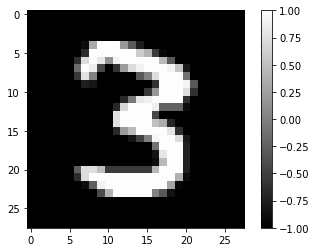

In [5]:
# Example: Normalized image. Values in [-1,1]
shw = plt.imshow(img[0].permute(1,2,0), cmap='gray')
plt.colorbar(shw)
plt.show()

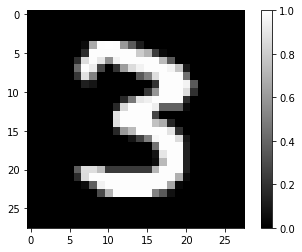

In [6]:
# Example: Denormalized image. Values in [0,1]
def denormalize(x):
    x = (x + 1) / 2
    return x

shw = plt.imshow(denormalize(img[0].permute(1,2,0)), cmap='gray')
plt.colorbar(shw)
plt.show()

## GAN

In [7]:
class Generator(nn.Module):
    def __init__(self, input_channels=64, output_channels=1, hidden_channels=64):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(input_channels, hidden_channels * 4, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_channels * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels * 4, hidden_channels * 2 , kernel_size=4, stride=1),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels * 2, hidden_channels, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels, output_channels, kernel_size=4, stride=2),
            nn.Tanh())

    def forward(self, x):
        # x: [batch_size, channels=latent_dimension, width=1, height=1]
        return self.generator(x)
        # [batch_size, channels=1, width=28, height=28]

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=16):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=4, stride=2),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels * 2, hidden_channels * 4, kernel_size=4, stride=1),
            nn.BatchNorm2d(hidden_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels * 4, 1, kernel_size=3, stride=2))

    def forward(self, x):
        # x: [batch_size, input_channels=1, 28, 28]
        return self.discriminator(x)

In [9]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

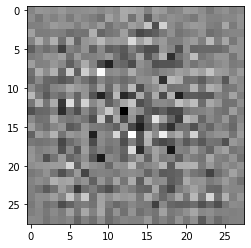

In [10]:
# Testing Generator
generator = Generator(input_channels = 64,  # latent_size
                      output_channels = 1,  # Number of channels of the image
                      hidden_channels = 64).to(device)

generator = generator.apply(init_weights)

noise_vector = noise_vector = torch.randn([1, 64, 1, 1], device=device)
# noise_vector: [batch_size=1, channels=latent_size=64, width=1, height=1]
fake_img = generator(noise_vector)
# fake_img: [batch_size, channels=1, width=28, height=28]
fake_img = denormalize(fake_img.detach().cpu().permute(0, 2, 3, 1))
plt.imshow(fake_img[0], cmap='gray')
plt.show()

## Training

In [11]:
# Parameters and hyperparameters
epochs = 50
latent_size = 64
lr = 2e-4
betas=(0.5, 0.999)
image_channels = 1

In [12]:
generator = Generator(input_channels = latent_size,
                      output_channels = image_channels,
                      hidden_channels = 64).to(device)
discriminator = Discriminator(input_channels = image_channels,
                              hidden_channels = 16).to(device)

generator = generator.apply(init_weights)
discriminator = discriminator.apply(init_weights)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

criterion = nn.BCEWithLogitsLoss()

In [13]:
output_dir = 'outputs'
images_dir = 'images'
images_path = os.path.join(output_dir, images_dir)

if not os.path.exists(images_path):
    os.makedirs(images_path)

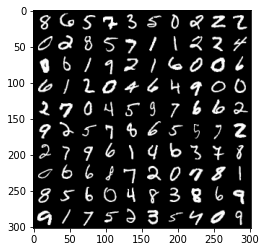

In [14]:
# Save some real images
img, _ = next(iter(train_loader))
img_grid = make_grid(denormalize(img), nrow=10)
save_image(img_grid, os.path.join(images_path , 'real_images.png'))

img = plt.imread(os.path.join(images_path , 'real_images.png'))
plt.imshow(img, cmap='gray')
plt.show()

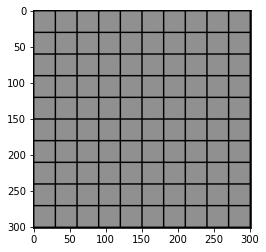

In [15]:
# Save fake images before training
def save_fake_images(idx, test_noise, file_path):
    # test_noise: [batch_size, channels=latent_size, width=1, height=1]
    fake_img = generator(test_noise)
    # fake_img: [batch_size, channels=1, width=28, height=28]
    fake_img_grid = make_grid(denormalize(fake_img).detach().cpu(), nrow=10)

    file_name = "fake_images-{0:0=4d}.png".format(idx)
    save_image(fake_img_grid, os.path.join(file_path, file_name))


test_noise = torch.randn([batch_size, latent_size, 1, 1], device=device)
# test_noise: [batch_size, channels=latent_size, width=1, height=1]
idx = 0

save_fake_images(idx, test_noise, images_path)
img = plt.imread(os.path.join(images_path, "fake_images-{0:0=4d}.png".format(idx)))
plt.imshow(img, cmap='gray')
plt.show()

100%|██████████| 600/600 [03:45<00:00,  2.66it/s]


Epoch: 1/50, g_loss: 1.3548745927214616, d_loss: 0.3689398267741006


100%|██████████| 600/600 [03:36<00:00,  2.77it/s]


Epoch: 2/50, g_loss: 3.7229264362653054, d_loss: 0.029083752827718877


100%|██████████| 600/600 [03:25<00:00,  2.92it/s]


Epoch: 3/50, g_loss: 5.146555651028952, d_loss: 0.007071658133063469


100%|██████████| 600/600 [03:29<00:00,  2.86it/s]


Epoch: 4/50, g_loss: 4.979459702173871, d_loss: 0.045149124350088346


100%|██████████| 600/600 [03:32<00:00,  2.82it/s]


Epoch: 5/50, g_loss: 4.750628792637337, d_loss: 0.09610059586353598


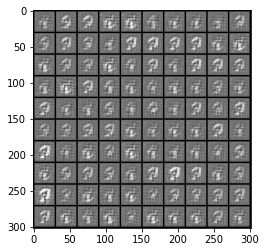

100%|██████████| 600/600 [03:34<00:00,  2.79it/s]


Epoch: 6/50, g_loss: 2.2443377429246882, d_loss: 0.2218658440560103


100%|██████████| 600/600 [03:32<00:00,  2.82it/s]


Epoch: 7/50, g_loss: 2.052401263589659, d_loss: 0.2486571766932805


100%|██████████| 600/600 [03:51<00:00,  2.59it/s]


Epoch: 8/50, g_loss: 1.9898553295433528, d_loss: 0.27504864813139057


100%|██████████| 600/600 [03:44<00:00,  2.67it/s]


Epoch: 9/50, g_loss: 1.8806618574261675, d_loss: 0.30259754496316116


100%|██████████| 600/600 [03:07<00:00,  3.19it/s]


Epoch: 10/50, g_loss: 1.689640294499695, d_loss: 0.34235708303749574


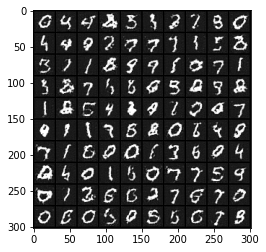

100%|██████████| 600/600 [03:13<00:00,  3.09it/s]


Epoch: 11/50, g_loss: 1.5895738879839578, d_loss: 0.37117015759150196


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 12/50, g_loss: 1.4380898454040285, d_loss: 0.4014258577426274


100%|██████████| 600/600 [03:11<00:00,  3.13it/s]


Epoch: 13/50, g_loss: 1.3841557559122637, d_loss: 0.41281934216618527


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 14/50, g_loss: 1.3569985316197068, d_loss: 0.42519693429271377


100%|██████████| 600/600 [03:13<00:00,  3.09it/s]


Epoch: 15/50, g_loss: 1.3455476124336345, d_loss: 0.42838279386361455


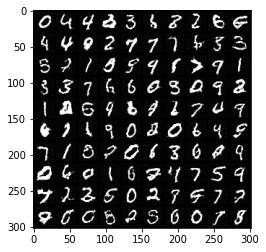

100%|██████████| 600/600 [03:09<00:00,  3.16it/s]


Epoch: 16/50, g_loss: 1.3347726499040924, d_loss: 0.43962835242350873


100%|██████████| 600/600 [03:09<00:00,  3.16it/s]


Epoch: 17/50, g_loss: 1.3147580894827846, d_loss: 0.44482442513108295


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 18/50, g_loss: 1.2877014300723868, d_loss: 0.45640539040168143


100%|██████████| 600/600 [03:11<00:00,  3.14it/s]


Epoch: 19/50, g_loss: 1.28908090159297, d_loss: 0.45342249254385647


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 20/50, g_loss: 1.2918222419669219, d_loss: 0.45832439397772196


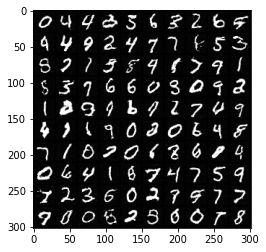

100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 21/50, g_loss: 1.2812295054892704, d_loss: 0.4572307082017261


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 22/50, g_loss: 1.2643012113869185, d_loss: 0.471741133779287


100%|██████████| 600/600 [03:09<00:00,  3.16it/s]


Epoch: 23/50, g_loss: 1.271583776300152, d_loss: 0.46539880757530544


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 24/50, g_loss: 1.2671501875420395, d_loss: 0.47061003729701


100%|██████████| 600/600 [03:09<00:00,  3.16it/s]


Epoch: 25/50, g_loss: 1.248395003676415, d_loss: 0.4841784796118738


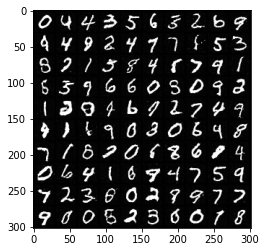

100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 26/50, g_loss: 1.243534309044479, d_loss: 0.4830106555422145


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 27/50, g_loss: 1.2455851743121955, d_loss: 0.4820437220235665


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 28/50, g_loss: 1.234912168681621, d_loss: 0.4840408593912919


100%|██████████| 600/600 [03:11<00:00,  3.13it/s]


Epoch: 29/50, g_loss: 1.2316782929499939, d_loss: 0.48612188547849666


100%|██████████| 600/600 [03:09<00:00,  3.16it/s]


Epoch: 30/50, g_loss: 1.2209562474737579, d_loss: 0.4920310585697492


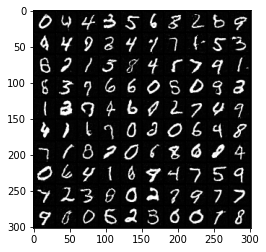

100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 31/50, g_loss: 1.2352151423941062, d_loss: 0.48730139568448055


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 32/50, g_loss: 1.228028434514999, d_loss: 0.49346273357669496


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 33/50, g_loss: 1.211420275022588, d_loss: 0.4934496150910859


100%|██████████| 600/600 [03:12<00:00,  3.12it/s]


Epoch: 34/50, g_loss: 1.2102421190341301, d_loss: 0.4923043383657932


100%|██████████| 600/600 [03:09<00:00,  3.16it/s]


Epoch: 35/50, g_loss: 1.2085161679486418, d_loss: 0.49637592896819144


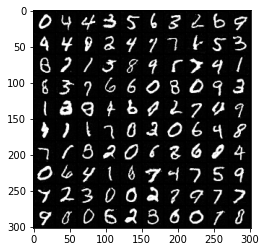

100%|██████████| 600/600 [03:09<00:00,  3.16it/s]


Epoch: 36/50, g_loss: 1.2134958217541372, d_loss: 0.4968827950954436


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 37/50, g_loss: 1.2126055643210814, d_loss: 0.4969700789948304


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 38/50, g_loss: 1.2185207454363516, d_loss: 0.49779209305842737


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 39/50, g_loss: 1.2082042677203817, d_loss: 0.4970559018353619


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 40/50, g_loss: 1.2204577704270683, d_loss: 0.49669644281268094


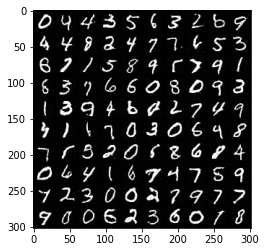

100%|██████████| 600/600 [03:11<00:00,  3.13it/s]


Epoch: 41/50, g_loss: 1.2068908720215177, d_loss: 0.4993931673467156


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 42/50, g_loss: 1.2146788427730406, d_loss: 0.5001472117006779


100%|██████████| 600/600 [03:11<00:00,  3.14it/s]


Epoch: 43/50, g_loss: 1.208801296899715, d_loss: 0.5002331848442552


100%|██████████| 600/600 [03:09<00:00,  3.16it/s]


Epoch: 44/50, g_loss: 1.2139457105596867, d_loss: 0.5049841553469497


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 45/50, g_loss: 1.2041505719224606, d_loss: 0.5048068952560423


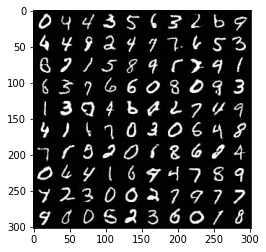

100%|██████████| 600/600 [03:11<00:00,  3.13it/s]


Epoch: 46/50, g_loss: 1.2070789491633571, d_loss: 0.5023263649642465


100%|██████████| 600/600 [03:10<00:00,  3.14it/s]


Epoch: 47/50, g_loss: 1.2040594641864282, d_loss: 0.5052208731571833


100%|██████████| 600/600 [03:12<00:00,  3.12it/s]


Epoch: 48/50, g_loss: 1.2033076835672063, d_loss: 0.505132263650497


100%|██████████| 600/600 [03:10<00:00,  3.15it/s]


Epoch: 49/50, g_loss: 1.2135614182551682, d_loss: 0.5098017730812233


100%|██████████| 600/600 [03:10<00:00,  3.16it/s]


Epoch: 50/50, g_loss: 1.2058081083993122, d_loss: 0.5097295117874938


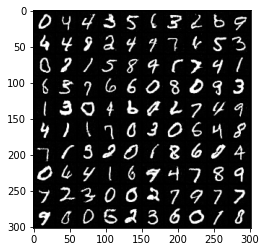

In [16]:
for epoch in range(1, epochs+1):
    mean_g_loss = 0
    mean_d_loss = 0
    for real_img, _ in tqdm(train_loader):
        # real_img: [batch_size, 1, 28, 28]
        real_img = real_img.to(device)

        ####################################
        #           Discriminator          #
        ####################################
        discriminator.train()

        # Loss for real images
        pred_real =  discriminator(real_img)
        target_real = torch.ones_like(pred_real).to(device)
        d_loss_real = criterion(pred_real, target_real)

        # Loss for fake images
        noise_vector = torch.randn([real_img.shape[0], latent_size, 1, 1], device=device)
        fake_img = generator(noise_vector)
        pred_fake = discriminator(fake_img.detach())
        target_fake = torch.zeros_like(pred_fake)
        d_loss_fake = criterion(pred_fake, target_fake)

        # Discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2

        # Backprop and optimize
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ####################################
        #             Generator            #
        ####################################
        generator.train()

        # Loss for fake images
        noise_vector = torch.randn([real_img.shape[0], latent_size, 1, 1], device=device)
        fake_img = generator(noise_vector)
        pred = discriminator(fake_img)
        target = torch.ones_like(pred).to(device)
        g_loss = criterion(pred, target)

        # Backprop and optimize
        g_optimizer.zero_grad()
        #d_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Stats
        mean_d_loss += d_loss.item() / len(train_loader)
        mean_g_loss += g_loss.item() / len(train_loader)

    save_fake_images(epoch, test_noise, images_path)

    # Verbose
    print(f"Epoch: {epoch}/{epochs}, g_loss: {mean_g_loss}, d_loss: {mean_d_loss}")

    # Visualization
    if (epoch % 5) == 0:
        img = plt.imread(os.path.join(images_path, "fake_images-{0:0=4d}.png".format(epoch)))
        plt.imshow(img, cmap='gray')
        plt.show()

## Saving

In [17]:
# Save the model checkpoints
checkpoint_dir = 'checkpoints'
checkpoints_path = os.path.join(output_dir, checkpoint_dir)

if not os.path.exists(checkpoints_path):
    os.makedirs(checkpoints_path)

torch.save(generator.state_dict(), os.path.join(checkpoints_path, 'generator.pt'))
torch.save(discriminator.state_dict(), os.path.join(checkpoints_path, 'discriminator.pt'))

In [19]:
# Make a gif
import glob
from PIL import Image

def make_gif(imgs_path, gif_filename):
    img_filename = os.path.join(imgs_path, "fake_images-*.png")
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(img_filename))]
    img.save(fp=gif_filename, format='GIF', append_images=imgs,
             save_all=True, duration=100, loop=0)

gif_filename = os.path.join(output_dir, "mnist_vanilla_gan_trainig.gif")
make_gif(images_path, gif_filename)

In [20]:
# Make a video
import cv2
import os
from IPython.display import FileLink

video_filename = os.path.join(output_dir, "mnist_vanilla_gan_trainig.avi")
frame_size = (302,302)  # img shape

out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'DIVX'), 16, frame_size)

files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if 'fake_images' in f]
files.sort()

for fname in files:
    img = cv2.imread(fname)
    out.write(img)

out.release()

## Testing

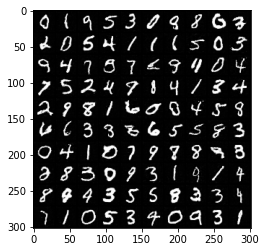

In [27]:
# Load saved model
generator = Generator(input_channels = latent_size,
                      output_channels = image_channels,
                      hidden_channels = 64).to(device)

generator.load_state_dict(torch.load('outputs/checkpoints/generator.pt'))
generator.eval()

# Generate fake image from noise vector
noise_tensor = torch.randn([batch_size, latent_size, 1, 1], device=device)

with torch.no_grad():
    fake_img = generator(noise_tensor)

fake_img = denormalize(fake_img).detach().cpu()
fake_img = make_grid(tensor=fake_img, nrow=10).permute(1,2,0)
# fake_img: [h,w,c], just one img

plt.imshow(fake_img, cmap='gray')
plt.show()


## References

* Generative Adversarial Nets [Goodfellow et al., 2014]: https://arxiv.org/pdf/1406.2661.pdf
* https://www.kaggle.com/vatsalmavani/deep-convolutional-gan-in-pytorch